<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/master/mlp_eeg_nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [35]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from os.path import join
import time
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from scipy.integrate import solve_ivp as ivp
from statistics import stdev

In [36]:
sfq = 250 # Было 250

In [37]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [38]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.
    square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [39]:
def normalize(arr):
    shape = arr.shape
    its = 1
    size = shape[-1]
    temp_arr = arr.flatten()
    for shape_i in shape:
        its *= shape_i
    its //= size
    for i in range(its - 1):
        temp_slice = temp_arr[i*size : (i+1)*size]
        temp_arr[i*size : (i+1)*size] = (temp_slice - np.min(temp_slice))/(np.max(temp_slice) - np.min(temp_slice))
    temp_slice = temp_arr[(i+1)*size:]
    temp_arr[(i+1)*size:] = (temp_slice - np.min(temp_slice))/(np.max(temp_slice) - np.min(temp_slice))
    return temp_arr.reshape(*shape)

In [40]:
r_mapping = {'O2': 0, 'O1': 1, 'P4': 2, 'P3': 3, 'C4': 4, 'C3': 5, 'F4': 6,
             'F3': 7, 'Fp2': 8, 'Fp1': 9, 'T6': 10, 'T5': 11, 'T4': 12,
             'T3': 13, 'F8': 14, 'F7': 15, 'Oz': 16, 'Pz': 17, 'Cz': 18,
             'Fz': 19, 'Fpz': 20, 'FT7': 21, 'FC3': 22, 'Fcz': 23, 'FC4': 24,
             'FT8': 25, 'TP7': 26, 'CP3': 27, 'Cpz': 28, 'CP4': 29, 'TP8': 30}
    

In [ ]:
def extract(data_stream):
    raw_data = data_stream.readlines()
    data = []
    for line in raw_data:
        temp = np.array([float(x) for x in line.split()])
        data.append(temp)
    return np.array(data)

def format_fname(_group, _hand, _subj, _tr_num):
    directory = 'drive/My Drive/Subjects'
    fname_pattern = f'{_group}_subject_{_subj}_{_hand}_tr_{_tr_num}.dat'
    return join(directory, fname_pattern)

hands = ('lefthand', 'righthand')
groups = ('OLD', 'YOUNG')
subjects = np.arange(1, 11)
trials = np.arange(1, 16)
total = len(hands)*len(groups)*len(subjects)*len(trials)

In [ ]:
epochs = []

for trial in trials:
    fin = open(format_fname('YOUNG', hands[1], subjects[0], trial))
    epochs.append(extract(fin))
    fin.close()

epochs = np.array(epochs)

In [ ]:
t = np.linspace(0, 12, 3001)
tp7 = epochs[::, r_mapping['TP7'], sfq*2::]
cz = epochs[::, r_mapping['Cz'], sfq*2::]
lowcut = 8.0
highcut = 12.0
cz_filtered = butter_bandpass_filter(cz, lowcut, highcut, sfq, order=6)
tp7_filtered = butter_bandpass_filter(tp7, lowcut, highcut, sfq, order=6)
temp = normalize(tp7_filtered)
tp7_filtered = np.array([(tp7_filtered[i] - np.min(tp7_filtered[i]))/(np.max(tp7_filtered[i]) - np.min(tp7_filtered[i])) for i in range(len(tp7_filtered))])
cz_filtered = np.array([(cz_filtered[i] - np.min(cz_filtered[i]))/(np.max(cz_filtered[i]) - np.min(cz_filtered[i])) for i in range(len(cz_filtered))])

In [103]:
def get_osc(epsylon=[0., 0.03], a=0.15, p=0.2, c=10, omega=[0.99, 0.95], fps=250, time=(0, 200)):
    def rossler(t, vec: np.array):
        res = np.zeros(6)
        x = vec[0:4:3]
        y = vec[1:5:3]
        z = vec[2:6:3]
        res[0:4:3] = -omega*y - z + epsylon*(x[::-1] - x)
        res[1:5:3] = omega*x + a*y
        res[2:6:3] = p + z*(x-c)
        return res
    omega = np.array(omega)
    epsylon = np.array(epsylon)
    start_time = time[0]
    end_time = time[1]
    X1 = 0
    Y1 = 1
    Z1 = 2
    X2 = 3
    Y2 = 4
    Z2 = 5
    t=np.linspace(start_time, end_time, num=int(fps*end_time))
    # z0 = np.array([ 4.2930454 ,  2.56096433,  0.03710937, -4.2591115 , -3.92001009, 0.01380057])
    z0 = np.zeros(6)
    res1 = ivp(rossler, (start_time,end_time), z0, t_eval=t)
    y = res1['y'] # тут данные с шейпом (6, <fps*(end_time - start_time)>). Эти шесть временных рядов -- значения x1, y1, z1, x2, y2, z2 соответственно
    t_span = res1['t'] # тут время (можно использовать то, что выше)
    return y
# osc1 = norm_osc_data[0:3].T # матрица вида [[X1_1, Y1_1, Z1_1], [X1_2, Y1_2, Z1_2], [X1_3, Y1_3, Z1_3], ...]
# osc2 = norm_osc_data[3:6].T # то же самое, что сверху, но только для X2, Y2, Z2

In [ ]:
###ADDED
### Рисует график обучения (loss function) и график метрики (coeff_determination). Своровано и адаптировано отсюда: https://www.tensorflow.org/tutorials/keras/regression?hl=ru
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Coefficient of determination')
    plt.plot(hist['epoch'], hist['coeff_determination'],
           label='Coefficient of determination')
    plt.plot(hist['epoch'], hist['loss'],
           label = 'Loss function')
    plt.ylim([0,5])
    plt.legend()
    plt.show()

In [74]:
from operator import sub

import numpy as np
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from toolz import curry
import warnings
warnings.filterwarnings('ignore')

# def reconstruct(tseries: np.array, n_dims, lag):
#     data = [np.arange(n_dims)*lag + i for i in range(tseries.shape[-1] - (n_dims - 1)*lag)]
#     return tseries[data]


################################
###### ЮЗАТЬ ЭТОТ МЕТОД ######
################################
# параметры для альфа частот (8-12 гц): 6 lag, 5 dims
# для теты (4-8 гц): 11 lag, 5 dims
def simple_recon(tseries: np.array, dims, lag):
    inds = [np.arange(0, dims)*lag + i for i in range(tseries.shape[-1] - (dims-1)*lag)]
    return tseries[inds].T


def reconstruct(x, lag, n_dims):
    x = _vector(x)

    if lag * (n_dims - 1) >= x.shape[0] // 2:
        raise ValueError('longest lag cannot be longer than half the length of x(t)')

    lags = lag * np.arange(n_dims)
    return np.vstack(x[lag:lag - lags[-1] or None] for lag in lags).transpose()

def global_false_nearest_neighbors(x, lag, min_dims=1, max_dims=10, **cutoffs):
    x = _vector(x)

    dimensions = np.arange(min_dims, max_dims + 1)
    false_neighbor_pcts = np.array([_gfnn(x, lag, n_dims, **cutoffs) for n_dims in dimensions])
    return dimensions, false_neighbor_pcts

def _gfnn(x, lag, n_dims, **cutoffs):
    offset = lag*n_dims
    is_true_neighbor = _is_true_neighbor(x, _radius(x), offset)
    return np.mean([
        not is_true_neighbor(indices, distance, **cutoffs)
        for indices, distance in _nearest_neighbors(reconstruct(x, lag, n_dims))
        if (indices + offset < x.size).all()
    ])

def _radius(x):
    return np.sqrt(((x - x.mean())**2).mean())

@curry
def _is_true_neighbor(
        x, attractor_radius, offset, indices, distance,
        relative_distance_cutoff=15,
        relative_radius_cutoff=2
):
    distance_increase = np.abs(sub(*x[indices + offset]))
    return (distance_increase / distance < relative_distance_cutoff and
            distance_increase / attractor_radius < relative_radius_cutoff)

def _nearest_neighbors(y):
    distances, indices = NearestNeighbors(n_neighbors=2, algorithm='kd_tree').fit(y).kneighbors(y)
    for distance, index in zip(distances, indices):
        yield index, distance[1]


def ami(x, y=None, n_bins=10):
    x, y = _vector_pair(x, y)
    if x.shape[0] != y.shape[0]:
        raise ValueError('timeseries must have the same length')
    return metrics.mutual_info_score(None, None, contingency=np.histogram2d(x, y, bins=n_bins)[0])

def lagged_ami(x, min_lag=0, max_lag=None, lag_step=1, n_bins=10):
    if max_lag is None:
        max_lag = x.shape[0]//2
    lags = np.arange(min_lag, max_lag, lag_step)

    amis = [ami(reconstruct(x, lag, 2), n_bins=n_bins) for lag in lags]
    return lags, np.array(amis)

def _vector_pair(a, b):
    a = np.squeeze(a)
    if b is None:
        if a.ndim != 2 or a.shape[1] != 2:
            raise ValueError('with one input, array must have be 2D with two columns')
        a, b = a[:, 0], a[:, 1]
    return a, np.squeeze(b)

def _vector(x):
    x = np.squeeze(x)
    if x.ndim != 1:
        raise ValueError('x(t) must be a 1-dimensional signal')
    return x

In [104]:
data = get_osc(fps=250)
# sos = lagged_ami(data, max_lag=500, n_bins=10)
# sas = global_false_nearest_neighbors(data, 6, max_dims=10)

In [118]:
r_data = reconstruct(data[0], 367, 3)

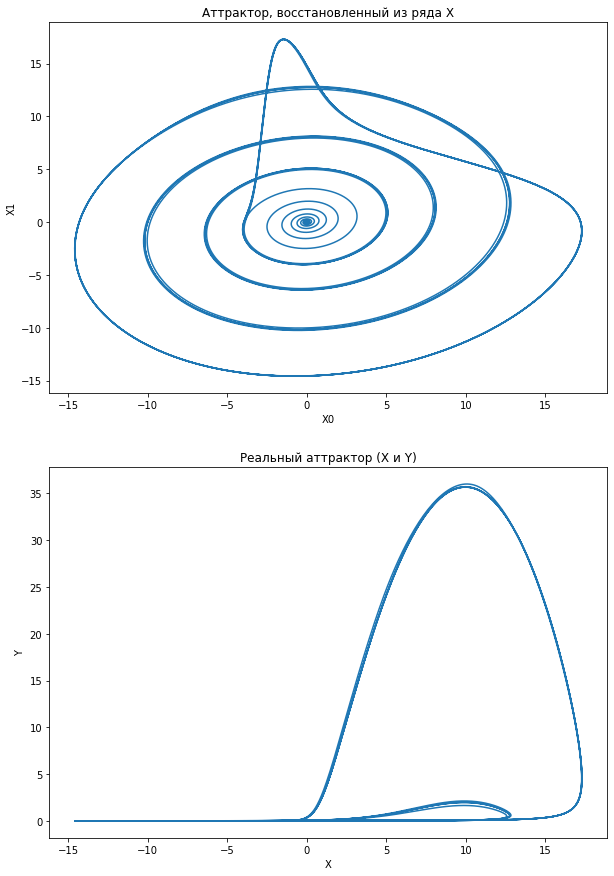

In [143]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(211)
ax.set_title('Аттрактор, восстановленный из ряда Х')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.plot(*r_data.T[[2, 1]])
ax1 = fig.add_subplot(212)
ax1.set_title('Реальный аттрактор (X и Y)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.plot(*get_osc(fps=250)[[0, 2]])

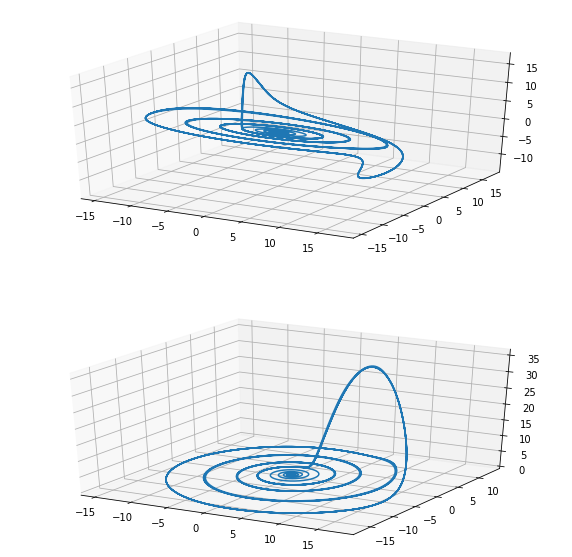

In [124]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211, projection='3d')
ax.plot(*r_data.T[[1, 2, 0]])
ax1 = fig.add_subplot(212, projection='3d')
ax1.plot(*data[:3])

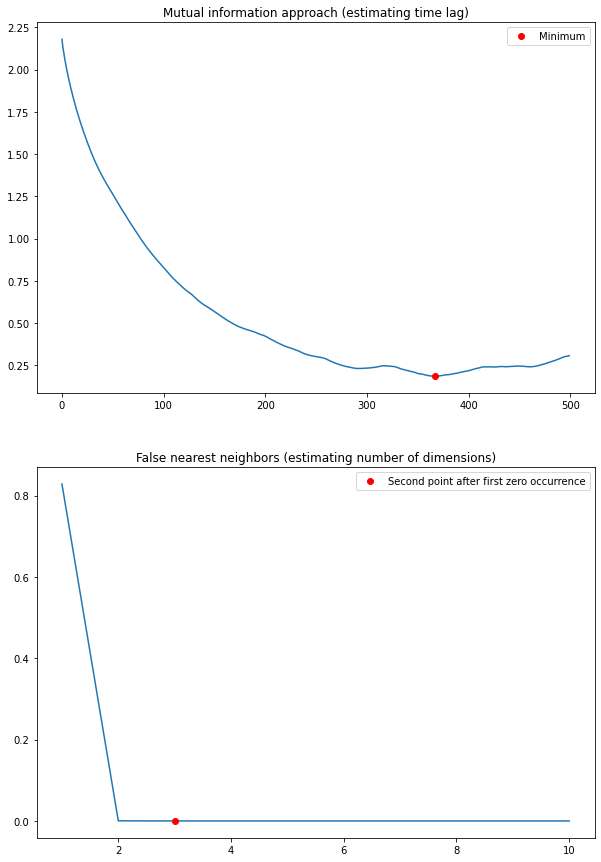

In [136]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(211)
ax.set_title('Mutual information approach (estimating time lag)')
ax.plot(*sos)
ax.plot(367, np.min(sos[1]), 'ro', label='Minimum')
ax.legend()
ax1 = fig.add_subplot(212)
ax1.set_title('False nearest neighbors (estimating number of dimensions)')
ax1.plot(*sas)
ax1.plot(3, 0, 'ro', label='Second point after first zero occurrence')
ax1.legend()
fig.savefig('sas.png')

In [145]:
help(np.squeeze)

Help on function squeeze in module numpy:

squeeze(a, axis=None)
    Remove single-dimensional entries from the shape of an array.
    
    Parameters
    ----------
    a : array_like
        Input data.
    axis : None or int or tuple of ints, optional
        .. versionadded:: 1.7.0
    
        Selects a subset of the single-dimensional entries in the
        shape. If an axis is selected with shape entry greater than
        one, an error is raised.
    
    Returns
    -------
    squeezed : ndarray
        The input array, but with all or a subset of the
        dimensions of length 1 removed. This is always `a` itself
        or a view into `a`.
    
    Raises
    ------
    ValueError
        If `axis` is not None, and an axis being squeezed is not of length 1
    
    See Also
    --------
    expand_dims : The inverse operation, adding singleton dimensions
    reshape : Insert, remove, and combine dimensions, and resize existing ones
    
    Examples
    --------
    >>> x